# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will work to understand the results of an A/B test run by an e-commerce website and help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

First, let's import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the seed to assure we will get the same answers every time we run the code
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#Check the number of rows in the dataset.
df.shape[0]

294478

In [4]:
#Check the number of unique users in the dataset.
df['user_id'].nunique()

290584

In [5]:
#Check the proportion of users converted.
df['converted'].mean()

0.11965919355605512

In [6]:
#Check the number of times the `new_page` and `treatment` don't match.
df[(df['group'] == 'treatment') != (df['landing_page'] == 'new_page')]['user_id'].count()

3893

In [7]:
#Check if any of the rows have missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


According to the information above, there is no missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  I choose just simply to drop those rows before further analysis.

In [8]:
#use .copy() to make sure it's a copy instead of a view to avoid potential SettingWithCopy problem later, which was usually caused by "chained" assignment.
df2 = df.query("(group == 'treatment') == (landing_page == 'new_page')").copy()

In [9]:
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[(df2['group'] == 'treatment') != (df2['landing_page'] == 'new_page')].shape[0]

0

`3.` Check the information in **df2** 

In [11]:
# Unique **user_id**s in **df2**
df2['user_id'].nunique()

290584

In [12]:
#There is one user_id repeated in df2.
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#The row information for the repeat **user_id**.
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
#Remove one of the rows with a duplicate user_id, but keep the dataframe as df2.
df2.drop_duplicates(subset="user_id",inplace=True)


In [67]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['landing_page'].count()/df2.shape[0]

0.5000619442226688

According to the information above, there is no sufficient evidence to say that the new treatment page leads to more conversions. Because no matter the indivisual is in "control" group or "treatment" group, the probability to convert is very similar, both close to 0.12.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` Consider we need to make the decision just based on all the data provided.  Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, here are our null and alternative hypotheses:

H0: 𝑝_𝑛𝑒𝑤 <=   𝑝_𝑜𝑙𝑑  or 𝑝_𝑛𝑒𝑤 - 𝑝_𝑜𝑙𝑑 <= 0

H1: 𝑝_𝑛𝑒𝑤 >   𝑝_𝑜𝑙𝑑  or 𝑝_𝑛𝑒𝑤 - 𝑝_𝑜𝑙𝑑 > 0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


In [20]:
# the conversion rate for 𝑝_𝑛𝑒𝑤 under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [21]:
# the conversion rate for 𝑝_𝑛𝑒𝑤 under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [22]:
# the number of individuals in the treatment group
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

In [23]:
# the number of individuals in the control group
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1,p_new,n_new)

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1,p_old,n_old)

Find $p_{new}$ - $p_{old}$ for the simulated values.

In [26]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0009244336000645281

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

Plot a histogram of the **p_diffs**.  

(array([  14.,   75.,  423., 1273., 2395., 2911., 1886.,  800.,  194.,
          29.]),
 array([-0.00462743, -0.00374505, -0.00286267, -0.00198029, -0.00109791,
        -0.00021553,  0.00066685,  0.00154923,  0.00243161,  0.00331399,
         0.00419637]),
 <a list of 10 Patch objects>)

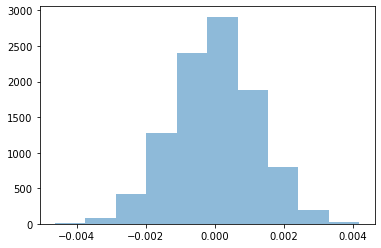

In [28]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs, alpha=0.5)

In [29]:
np.std(p_diffs)

0.0012084469907426081

In [30]:
p_diff_df2 = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
p_diff_df2

-0.0015782389853555567

Yes, the plot looks like what I expected.  It's close to normally distributed, which Accords with the Central Limit Theorem. Its mean is also very close to the population mean (-0.0016). This accords with the Law of Large Numbers.

The proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv** (P-value)

In [32]:
(p_diffs > p_diff_df2).mean()

0.904

Since the P-value is large(0.9), we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null. It means there is no much difference between the new and old pages.

We could also use a built-in to achieve similar results. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:

import statsmodels.api as sm

# Since the control group received old page and the treatment group received new page, 
# we can just calculate the number of conversions for each group

# convert_old, convert_new store the number of conversions for each page

convert_old = len(df2.query('group == "control" & converted == 1'))
convert_new = len(df2.query('group == "treatment" & converted == 1'))

#n_old, n_new store the number of individuals who received each page.
n_old = df2.query('group == "control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Now use `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
# use stats.proportions_ztest to compute the test statistic and p-value

count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
# becuase our alternative hypothesis is 𝑝_𝑛𝑒𝑤 > 𝑝_𝑜𝑙𝑑, we set parameter of alternative to "larger"
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative='larger')

stat, pval

(-1.3109241984234394, 0.9050583127590245)

z-score(-1.31) means the standard deviations away from the mean. And p-value is 0.905, which is consistent with the sampling distribution we performed. Since the p-value is large we cannot reject the null hypothsis. It means there is no much difference between the old and new pages.

<a id='regression'></a>
### Part III - A regression approach


`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.Since there are only two possible outcome, Logistic Regression would be the best for this case.

In [38]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to instantiate the regression model on the two columns we created above, then fit the model using the two columns we created to predict whether or not an individual converts. 

In [39]:
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 25 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        10:23:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [41]:
1/np.exp(-0.0150)

1.015113064615719

If an individual received old page, they are 1.015 times more likely to convert than if they received new page, holding all other variables constant.

The p-value associated with ab_page is 0.190. But the p-value in Part II is 0.9057. They are different because in the logistic regression model the null hypotheses is p_new = p_old, which is two-tailed. However in Part II the null hypotheses is the difference between the new page and the old page, p_new-p_old <=0, which is one-tailed.  So the p-value in logistic regression model is 2 times than the value in Part II.


There are some other things we can consider that might influence whether or not an individual converts, for example the time(weekday or weekend, day or evening) an individual accessed the page, an indidual's age, the region an individual is located in, etc.  Because all these things might also influence the conversion. But these additional terms might interact each other which might cause unexpected result in the regression model.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [44]:
# check what countries are in the dataset.
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [45]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('CA',axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [46]:
lm_2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
results_2 = lm_2.fit()
results_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 25 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        10:26:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [47]:
np.exp(0.0408), np.exp(0.0506)

(1.0416437559600236, 1.0519020483004984)

Summary:
If an individual received old page, they are 1.015 times more likely to convert than if they received new page, holding all other variables constant.
The conversion is 1.04 times more likely on the individual in US than the individual in CA, holding all other variables constant.
The conversion is 1.05 times more likely on the individual in UK than the individual in CA, holding all other variables constant

Finally we would like to look at an interaction between page and country to see if there significant effects on conversion.  

In [48]:
### Fit Your Linear Model And Obtain the Results
lm_3 = sm.OLS(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
result_3 = lm_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Fri, 25 Oct 2019   Prob (F-statistic):              0.178
Time:                        10:28:57   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1161      0.003     42.036      0.000       0.111       0.122
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
US             0.0042      0.003      1.514      0.130      -0.001       0.010
UK             0.0053      0.003      1.784      0.074      -0.001       0.011
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
import seaborn as sns

sns.pairplot(df_new[['ab_page', 'US', 'UK']]);

ModuleNotFoundError: No module named 'seaborn'

The pair plots showed there is no direct interact between the ab_page and countries. And the p-values for ab_page, US, and UK are all over 0.05, which means they are not statistically significant with the conversion and we cannot reject the null hypothsis. There is no much difference between the old and new pages.
The R-square is 0. It shows the Linear Model is not a good model to explain our dataset. 

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0